## Introduction


# Train a Deep Q Network with fNIRS data


## Setup

In [45]:
# !python --version
# #3.7.11

# #install python 3.8
# !sudo apt-get update -y
# !sudo apt-get install python3.8

# #change alternatives
# !sudo update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.7 1
# !sudo update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.8 2

# #check python version
# !python --version
# #3.8.13

# #If nothing changed after installation, use this command to select python version manually
# #after running, enter the row number of the python version you want.
# # !sudo update-alternatives --config python3


# # to install pip
# !wget https://bootstrap.pypa.io/get-pip.py
# # If you get an error like No module named 'distutils.util' when you run python3.8 get-pip.py, 
# # and you are on a Debian-based Linux distribution, run
# !sudo apt install python3.8-distutils
# !python3.8 get-pip.py
# # It is important you use python3.9 instead of just python3, to ensure pip is installed for python 3.8.

# # If you see any permissions errors, you may need to use
# # !python3.8 get-pip.py --user



If you haven't installed the following dependencies, run:

In [46]:
!python --version

Python 3.9.9


In [47]:
# !sudo apt-get update
# !sudo apt-get install -y xvfb ffmpeg freeglut3-dev
# !pip install --upgrade pip
# !pip install 'numpy>=1.21.0'
# !pip install 'imageio==2.4.0'
# !pip install pyvirtualdisplay
# !pip install "tf-agents[reverb]==0.12.0"
# !pip install pyglet
# !pip install box2d-py
# # for the atari games, make sure you install gym with atari and accept-rom-license
# # options to import ROMs. For this, make sure version 0.21.0 is installed
# !pip install gym[Box_2D]

In [48]:
import base64
import imageio
import IPython
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import pyvirtualdisplay
import reverb
import gym

import tensorflow as tf
from functools import partial

from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import py_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment

from tf_agents.environments import atari_wrappers
from tf_agents.environments import py_environment

from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import sequential
from tf_agents.networks import q_network
from tf_agents.policies import py_tf_eager_policy
from tf_agents.policies import random_tf_policy
from tf_agents.policies import epsilon_greedy_policy
from tf_agents.replay_buffers import reverb_replay_buffer
from tf_agents.replay_buffers import reverb_utils
from tf_agents.trajectories import trajectory
from tf_agents.specs import tensor_spec
from tf_agents.utils import common
from tf_agents.train.utils import train_utils



In [49]:
# Set up a virtual display for rendering OpenAI gym environments.
display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()

## Hyperparameters

In [50]:
num_iterations = 100000 # @param {type:"integer"}

initial_collect_steps = 100  # @param {type:"integer"}
collect_steps_per_iteration =   1# @param {type:"integer"}
replay_buffer_max_length = 1000  # @param {type:"integer"}

batch_size = 64  # @param {type:"integer"}
learning_rate = 25e-5  # @param {type:"number"}
log_interval = 200  # @param {type:"integer"}

num_eval_episodes = 10  # @param {type:"integer"}
eval_interval = 1000  # @param {type:"integer"}

## Environment

In Reinforcement Learning (RL), an environment represents the task or problem to be solved. Standard environments can be created in TF-Agents using `tf_agents.environments` suites. TF-Agents has suites for loading environments from sources such as the OpenAI Gym, Atari, and DM Control.

Load the PacMan environment from the OpenAI Gym suite. 

In [51]:
from gym import wrappers
env_name = "LunarLander-v2"

#initial environment
env = suite_gym.load(env_name)

You can render this environment to see how it looks. A free-swinging pole is attached to a cart.  The goal is to move the cart right or left in order to keep the pole pointing up.

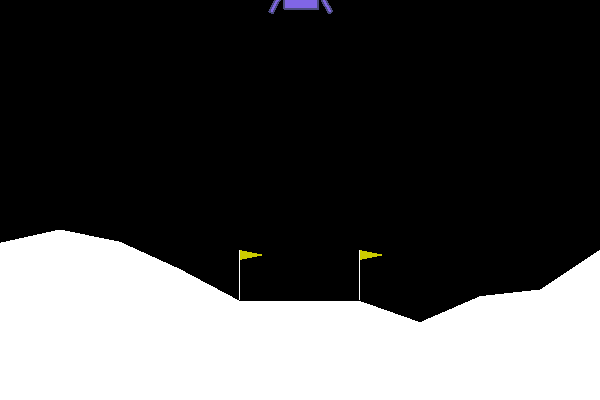

In [52]:
#@test {"skip": true}
env.reset()
PIL.Image.fromarray(env.render())

The `environment.step` method takes an `action` in the environment and returns a `TimeStep` tuple containing the next observation of the environment and the reward for the action.

The `time_step_spec()` method returns the specification for the `TimeStep` tuple. Its `observation` attribute shows the shape of observations, the data types, and the ranges of allowed values. The `reward` attribute shows the same details for the reward.


In [53]:
print('Observation Spec:')
print(env.time_step_spec().observation)

Observation Spec:
BoundedArraySpec(shape=(8,), dtype=dtype('float32'), name='observation', minimum=-3.4028234663852886e+38, maximum=3.4028234663852886e+38)


In [54]:
print('Reward Spec:')
print(env.time_step_spec().reward)

Reward Spec:
ArraySpec(shape=(), dtype=dtype('float32'), name='reward')


The `action_spec()` method returns the shape, data types, and allowed values of valid actions.

In [55]:
print('Action Spec:')
print(env.action_spec())

Action Spec:
BoundedArraySpec(shape=(), dtype=dtype('int64'), name='action', minimum=0, maximum=3)


In the PacMan environment:

-   `observation` is an RGB picture of size $210\times160$. Each frame represents: 
    -   the position of the PacMan and ghosts
    -   the position of rewards and goals 
-   `reward` is a scalar float value
-   `action` is a scalar integer with only 9 possible values:
    -   `0` — "no move"
    -   `1` — "move right"
    -   `2` — "move right"
    -   `3` — "move left"
    -   `4` — "move down"
    -   `5` — "move upright"
    -   `6` — "move upleft"
    -   `7` — "move downright"
    -   `8` — "move downleft"



Time step:
Next time step:


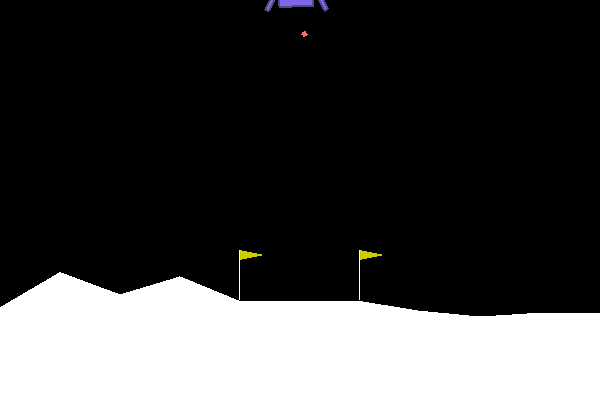

In [56]:
time_step = env.reset()
print('Time step:')
PIL.Image.fromarray(env.render())

action = np.array(2, dtype=np.int32)
next_time_step = env.step(action)
print('Next time step:')
PIL.Image.fromarray(env.render())

In [57]:
env.observation_spec().shape

(8,)

Usually two environments are instantiated: one for training and one for evaluation. 

In [58]:
train_py_env = suite_gym.load(env_name)
eval_py_env = suite_gym.load(env_name)

The Pacman environment, like most environments, is written in pure Python. This is converted to TensorFlow using the `TFPyEnvironment` wrapper.

The original environment's API uses Numpy arrays. The `TFPyEnvironment` converts these to `Tensors` to make it compatible with Tensorflow agents and policies.


In [59]:
train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

## Agent

The algorithm used to solve an RL problem is represented by a   [DQN](https://storage.googleapis.com/deepmind-media/dqn/DQNNaturePaper.pdf) `Agent`. The DQN agent can be used in any environment which has a discrete action space.

At the heart of a DQN Agent is a `QNetwork`, a neural network model that can learn to predict `QValues` (expected returns) for all actions, given an observation from the environment.

The `QNetwork` will consist of a sequence of `tf.keras.layers.Dense` layers, where the final layer will have 1 output for each possible action.

In [60]:
from tf_agents.networks import encoding_network

np.random.seed(42)
tf.random.set_seed(42)

n_inputs = env.observation_space.shape[0] # (8,)
n_outputs = env.action_space.n            # 4

fc_layer_params = [64,128,64]
weight_decay_params = [0.0001] * 3
class qNet(q_network.QNetwork):
    def __init__(self, input_tensor_spec, action_spec, **kwargs):
        super().__init__(input_tensor_spec, action_spec, **kwargs)

        self._encoder = encoding_network.EncodingNetwork(
            input_tensor_spec,
            fc_layer_params=fc_layer_params,
            weight_decay_params=weight_decay_params)

    

# q_net = q_network.QNetwork(
q_net = qNet(
    train_env.observation_spec(),
    train_env.action_spec(),
    fc_layer_params=fc_layer_params,
    name='QNetwork')
update_period = 4
epsilon_fn  = tf.optimizers.schedules.PolynomialDecay(
                  initial_learning_rate = 0.1,
                  decay_steps = 250000//update_period,
                  end_learning_rate = 0.01
                  )

optimizer = tf.optimizers.Adam(learning_rate=learning_rate)
global_step = train_utils.create_train_step()

#########################################################################
agent = dqn_agent.DqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    target_update_period=2000,
    td_errors_loss_fn=tf.keras.losses.Huber(reduction='none'),
    gamma=0.99,
    train_step_counter=global_step,
    epsilon_greedy=lambda:epsilon_fn(global_step),
    gradient_clipping=None,
    summarize_grads_and_vars=True,
    debug_summaries=True)

agent.initialize()

Now use `tf_agents.agents.dqn.dqn_agent` to instantiate a `DqnAgent`. In addition to the `time_step_spec`, `action_spec` and the QNetwork, the agent constructor also requires an optimizer (in this case, `AdamOptimizer`), a loss function, and an integer step counter.

In [61]:
q_net.summary()

Model: "QNetwork"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_29 (Dense)             multiple                  260       
_________________________________________________________________
EncodingNetwork (EncodingNet multiple                  17152     
Total params: 17,412
Trainable params: 17,412
Non-trainable params: 0
_________________________________________________________________


## Policies

A policy defines the way an agent acts in an environment. Typically, the goal of reinforcement learning is to train the underlying model until the policy produces the desired outcome.

In this tutorial:

-   The desired outcome is keeping the pole balanced upright over the cart.
-   The policy returns an action (left or right) for each `time_step` observation.

Agents contain two policies: 

-   `agent.policy` — The main policy that is used for evaluation and deployment.
-   `agent.collect_policy` — A second policy that is used for data collection.


In [62]:
eval_policy = agent.policy
collect_policy = agent.collect_policy

Policies can be created independently of agents. For example, use `tf_agents.policies.random_tf_policy` to create a policy which will randomly select an action for each `time_step`.

In [63]:
random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())

To get an action from a policy, call the `policy.action(time_step)` method. The `time_step` contains the observation from the environment. This method returns a `PolicyStep`, which is a named tuple with three components:

-   `action` — the action to be taken (in this case, `0` or `1`)
-   `state` — used for stateful (that is, RNN-based) policies
-   `info` — auxiliary data, such as log probabilities of actions

In [64]:
example_environment = tf_py_environment.TFPyEnvironment(
    suite_gym.load(env_name))

In [65]:
time_step = example_environment.reset()
time_step

TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 8), dtype=float32, numpy=
array([[ 0.00363855,  1.4212785 ,  0.3685164 ,  0.46036536, -0.00420924,
        -0.0834745 ,  0.        ,  0.        ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})

In [66]:
random_policy.action(time_step)

PolicyStep(action=<tf.Tensor: shape=(1,), dtype=int64, numpy=array([3])>, state=(), info=())

## Metrics and Evaluation

The most common metric used to evaluate a policy is the average return. The return is the sum of rewards obtained while running a policy in an environment for an episode. Several episodes are run, creating an average return.

The following function computes the average return of a policy, given the policy, environment, and a number of episodes.


In [67]:
#@test {"skip": true}
def compute_avg_return(environment, policy, num_episodes=10):

  total_return = 0.0
  for _ in range(num_episodes):

    time_step = environment.reset()
    episode_return = 0.0

    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
    total_return += episode_return

  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]


# See also the metrics module for standard implementations of different metrics.
# https://github.com/tensorflow/agents/tree/master/tf_agents/metrics

Running this computation on the `random_policy` shows a baseline performance in the environment.

In [68]:
compute_avg_return(eval_env, random_policy, num_eval_episodes)

-211.42363

## Replay Buffer

In order to keep track of the data collected from the environment, we will use [Reverb](https://deepmind.com/research/open-source/Reverb), an efficient, extensible, and easy-to-use replay system by Deepmind. It stores experience data when we collect trajectories and is consumed during training.

This replay buffer is constructed using specs describing the tensors that are to be stored, which can be obtained from the agent using agent.collect_data_spec.


In [69]:
table_name = 'uniform_table'
replay_buffer_signature = tensor_spec.from_spec(
      agent.collect_data_spec)
replay_buffer_signature = tensor_spec.add_outer_dim(
    replay_buffer_signature)

table = reverb.Table(
    table_name,
    max_size=replay_buffer_max_length,
    sampler=reverb.selectors.Uniform(),
    remover=reverb.selectors.Fifo(),
    rate_limiter=reverb.rate_limiters.MinSize(1),
    signature=replay_buffer_signature)

reverb_server = reverb.Server([table])

replay_buffer = reverb_replay_buffer.ReverbReplayBuffer(
    agent.collect_data_spec,
    table_name=table_name,
    sequence_length=2,
    local_server=reverb_server)

rb_observer = reverb_utils.ReverbAddTrajectoryObserver(
  replay_buffer.py_client,
  table_name,
  sequence_length=2)

# from tf_agents.replay_buffers import tf_uniform_replay_buffer
 
# replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
#                                             data_spec = agent.collect_data_spec,
#                                             batch_size = tf_env.batch_size,
#                                             max_length = 100000 # # reduce if OOM error
#                 )
# replay_buffer_observer = replay_buffer.add_batch

# rb_observer = replay_buffer.add_batch

[reverb/cc/platform/tfrecord_checkpointer.cc:150]  Initializing TFRecordCheckpointer in /tmp/tmpplze93a9.
[reverb/cc/platform/tfrecord_checkpointer.cc:386] Loading latest checkpoint from /tmp/tmpplze93a9
[reverb/cc/platform/default/server.cc:71] Started replay server on port 19346


For most agents, `collect_data_spec` is a named tuple called `Trajectory`, containing the specs for observations, actions, rewards, and other items.

In [70]:
agent.collect_data_spec

Trajectory(
{'action': BoundedTensorSpec(shape=(), dtype=tf.int64, name='action', minimum=array(0), maximum=array(3)),
 'discount': BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)),
 'next_step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type'),
 'observation': BoundedTensorSpec(shape=(8,), dtype=tf.float32, name='observation', minimum=array(-3.4028235e+38, dtype=float32), maximum=array(3.4028235e+38, dtype=float32)),
 'policy_info': (),
 'reward': TensorSpec(shape=(), dtype=tf.float32, name='reward'),
 'step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type')})

In [71]:
agent.collect_data_spec._fields

('step_type',
 'observation',
 'action',
 'policy_info',
 'next_step_type',
 'reward',
 'discount')

## Data Collection

Now execute the random policy in the environment for a few steps, recording the data in the replay buffer.

Here we are using 'PyDriver' to run the experience collecting loop. You can learn more about TF Agents driver in our [drivers tutorial](https://www.tensorflow.org/agents/tutorials/4_drivers_tutorial).

In [72]:
#@test {"skip": true}
py_driver.PyDriver(
    env,
    py_tf_eager_policy.PyTFEagerPolicy(
      random_policy, use_tf_function=True),
    [rb_observer],
    max_steps=initial_collect_steps).run(train_py_env.reset());

The replay buffer is now a collection of Trajectories.

In [73]:
# For the curious:
# Uncomment to peel one of these off and inspect it.
iter(replay_buffer.as_dataset()).next()

(Trajectory(
 {'action': <tf.Tensor: shape=(2,), dtype=int64, numpy=array([0, 3])>,
  'discount': <tf.Tensor: shape=(2,), dtype=float32, numpy=array([1., 1.], dtype=float32)>,
  'next_step_type': <tf.Tensor: shape=(2,), dtype=int32, numpy=array([1, 1], dtype=int32)>,
  'observation': <tf.Tensor: shape=(2, 8), dtype=float32, numpy=
 array([[-0.46053475,  1.333678  , -0.85777104, -0.37836167,  0.42221865,
          0.16145286,  0.        ,  0.        ],
        [-0.469038  ,  1.3246156 , -0.85776776, -0.40503338,  0.43029127,
          0.16145214,  0.        ,  0.        ]], dtype=float32)>,
  'policy_info': (),
  'reward': <tf.Tensor: shape=(2,), dtype=float32, numpy=array([-1.3400184 , -0.26673284], dtype=float32)>,
  'step_type': <tf.Tensor: shape=(2,), dtype=int32, numpy=array([1, 1], dtype=int32)>}),
 SampleInfo(key=<tf.Tensor: shape=(2,), dtype=uint64, numpy=array([16171563789363169661, 16171563789363169661], dtype=uint64)>, probability=<tf.Tensor: shape=(2,), dtype=float64, numpy=

The agent needs access to the replay buffer. This is provided by creating an iterable `tf.data.Dataset` pipeline which will feed data to the agent.

Each row of the replay buffer only stores a single observation step. But since the DQN Agent needs both the current and next observation to compute the loss, the dataset pipeline will sample two adjacent rows for each item in the batch (`num_steps=2`).

This dataset is also optimized by running parallel calls and prefetching data.

In [74]:
# Dataset generates trajectories with shape [Bx2x...]
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3,
    sample_batch_size=batch_size,
    num_steps=2).prefetch(3)

In [75]:
iterator = iter(dataset)
# print(iterator)

[reverb/cc/platform/default/server.cc:84] Shutting down replay server


In [76]:
# For the curious:
# Uncomment to see what the dataset iterator is feeding to the agent.
# Compare this representation of replay data 
# to the collection of individual trajectories shown earlier.

# iterator.next()

## Training the agent

Two things must happen during the training loop:

-   collect data from the environment
-   use that data to train the agent's neural network(s)

This example also periodicially evaluates the policy and prints the current score.

The following will take ~5 minutes to run.

In [77]:
#@test {"skip": true}
try:
  %%time
except:
  pass

# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)

# Reset the train step.
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
returns = [avg_return]

# Reset the environment.
time_step = train_py_env.reset()

# Create a driver to collect experience.
collect_driver = py_driver.PyDriver(
    env,
    py_tf_eager_policy.PyTFEagerPolicy(
      agent.collect_policy, use_tf_function=True),
    [rb_observer],
    max_steps=collect_steps_per_iteration)

for episode in range(num_iterations):
  # print('episode = ', episode)
  # Collect a few steps and save to the replay buffer.
  time_step, _ = collect_driver.run(time_step)

  # Sample a batch of data from the buffer and update the agent's network.
  experience, unused_info = next(iterator)
  train_loss = agent.train(experience).loss

  step = agent.train_step_counter.numpy()

  if step % log_interval == 0:
    print('step = {0}: loss = {1}'.format(step, train_loss))

  if step % eval_interval == 0:
    avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
    print('step = {0}: Average Return = {1}'.format(step, avg_return))
    returns.append(avg_return)

[reverb/cc/client.cc:163] Sampler and server are owned by the same process (3582799) so Table uniform_table is accessed directly without gRPC.


step = 200: loss = 2.3890857696533203
step = 400: loss = 2.1662232875823975
step = 600: loss = 1.1031970977783203
step = 800: loss = 0.38126224279403687
step = 1000: loss = 0.6506985425949097
step = 1000: Average Return = -188.41439819335938
step = 1200: loss = 0.5468297600746155
step = 1400: loss = 0.6152358651161194
step = 1600: loss = 0.6137257814407349
step = 1800: loss = 2.465322971343994
step = 2000: loss = 1.1572787761688232
step = 2000: Average Return = -563.9483642578125
step = 2200: loss = 0.9511843323707581
step = 2400: loss = 1.278730034828186
step = 2600: loss = 1.982263445854187
step = 2800: loss = 1.6078832149505615
step = 3000: loss = 1.5369770526885986
step = 3000: Average Return = -69.49842071533203
step = 3200: loss = 1.8372015953063965
step = 3400: loss = 1.1284713745117188
step = 3600: loss = 0.5741382241249084
step = 3800: loss = 1.9801689386367798
step = 4000: loss = 0.647993803024292
step = 4000: Average Return = -36.944847106933594
step = 4200: loss = 1.1462243

## Visualization


### Plots

Use `matplotlib.pyplot` to chart how the policy improved during training.

(-605.6192962646485, 300.0)

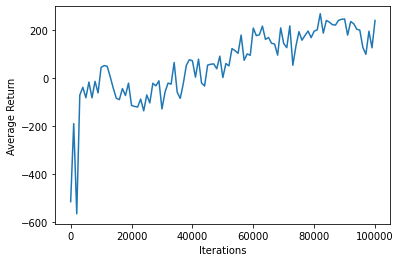

In [82]:
#@test {"skip": true}

iterations = range(0, num_iterations + 1, eval_interval)
plt.plot(iterations, returns)
plt.ylabel('Average Return')
plt.xlabel('Iterations')
plt.ylim(top=300)

### Videos

Charts are nice. But more exciting is seeing an agent actually performing a task in an environment. 

First, create a function to embed videos in the notebook.

In [79]:
def embed_mp4(filename):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)

The underlying Python environment (the one "inside" the TensorFlow environment wrapper) provides a `render()` method, which outputs an image of the environment state. These can be collected into a video.

In [80]:
def create_policy_eval_video(policy, filename, num_episodes=5, fps=30):
  filename = filename + ".mp4"
  with imageio.get_writer(filename, fps=fps) as video:
    for _ in range(num_episodes):
      time_step = eval_env.reset()
      video.append_data(eval_py_env.render())
      while not time_step.is_last():
        action_step = policy.action(time_step)
        time_step = eval_env.step(action_step.action)
        video.append_data(eval_py_env.render())
  return embed_mp4(filename)

create_policy_eval_video(agent.policy, "trained-agent")

[swscaler @ 0x55b023b34d00] Warning: data is not aligned! This can lead to a speed loss


For fun, compare the trained agent (above) to an agent moving randomly. (It does not do as well.)

In [81]:
# create_policy_eval_video(random_policy, "random-agent")